# **Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Dependencies Installieren

In [ ]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

2. Package importieren

In [3]:
#Packung für das Sammeln durch den Webcam
import os, time, uuid, cv2
from pathlib import Path

In [4]:
#Packung für Bilderverarbeitung
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [5]:
#Packung für die Ablumentation und die Bildung der Data-Pipeline
import albumentations as alb

In [6]:
#Packung für das Modelbau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [7]:
#Model Speicherung
from tensorflow.keras.models import load_model

# Bilder mit passenden Namen versehen (Umbenennung)

In [8]:
# Da ich mit Google Colab arbeiten, ist die Name meines Paths anderes bei euch. Allerdings ist dieser Teil nur für mich wichtig, deshalb musst ihr dieses Teil auch nicht activieren.
%cd "/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI"

/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI


In [ ]:
image_path = "data/test/images"

In [ ]:
%cd "/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI/{image_path}"

/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI/data/test/images


In [9]:
current_path = Path().resolve()
print(current_path)

/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI


In [ ]:
x = 1
for file in os.listdir():
  old_name = os.path.join(current_path, file)
  new_name = os.path.join(current_path,f"image{x}.jpg")
  os.rename(old_name, new_name)
  x+=1

In [10]:
%pwd

'/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI'

# Bilder labeln

In [ ]:
!labelme

Labelme öffnen, um Ausgangsdaten mit Labels zu versehen, dort wo Gesichter zu sehen sind (nach Akzepentanzkritierien PROJ-71)

Rechteck um das Gesicht, wenn kein Gesicht vorhanden Datei ignorieren

Labels als json in den labels Ordner übertragen

# **3. Die gesamte Datenmenge in kleineren Gruppen aufteilen**

Shuffling


In [ ]:
import random

In [ ]:
l = os.listdir(current_path)
random.shuffle(l)
print(l)

['image61.jpg', 'image60.jpg', 'image32.jpg', 'image37.jpg', 'image1.jpg', 'image82.jpg', 'image46.jpg', 'image22.jpg', 'placeholder', 'image23.jpg', 'image85.jpg', 'image83.jpg', 'image16.jpg', 'image36.jpg', 'image7.jpg', 'image57.jpg', 'image44.jpg', 'image66.jpg', 'image79.jpg', 'image54.jpg', 'image34.jpg', 'image6.jpg', 'image35.jpg', 'image9.jpg', 'image11.jpg', 'image77.jpg', 'image63.jpg']


Trennung (Dieses Teil musst ihr nicht aktivieren)

In [ ]:
#training_set
for x in range(int(len(l)*0.7)+1):
  file = l[x]
  EX_PATH = os.path.join("data","images",file)
  NEW_PATH = os.path.join("data","train","images",file)
  os.replace(EX_PATH,NEW_PATH)

In [ ]:
#testing_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','images',file)
  NEW_PATH = os.path.join('data','test','images',file)
  os.replace(EX_PATH,NEW_PATH)
  

In [ ]:
#validation_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','test','images',file)
  NEW_PATH = os.path.join('data','val','images',file)
  os.replace(EX_PATH,NEW_PATH)

Die Labels auch trennen

In [ ]:
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)

# **4. Albumentation Setting für die Augmentatition den Bildern aufstellen**

In [87]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)], 
                        bbox_params= alb.BboxParams(format="albumentations",label_fields=["class_labels"]))

Laden eines Beispielbilds

In [11]:
img = cv2.imread(os.path.join('data','train','images','image38.jpg'))

In [51]:
size= img.shape
print(size)

(1103, 736, 3)


In [12]:
with open(os.path.join('data','train','labels','image38.json'),'r') as f:
  label = json.load(f)

In [64]:
label['shapes'][0]['points']



[[95.82352941176475, 75.17647058823529], [497.0, 548.1176470588235]]

Koordinaten Extrahieren und Maßstab ändern

In [65]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [66]:
coords

[95.82352941176475, 75.17647058823529, 497.0, 548.1176470588235]

In [67]:
coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

In [68]:
coords

[0.13019501278772386,
 0.06815636499386699,
 0.6752717391304348,
 0.4969334968801664]

Augmentation implimentieren

In [101]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [76]:
augmented['bboxes'][0][2:]


(0.7483333333333333, 0.17019607843137255)

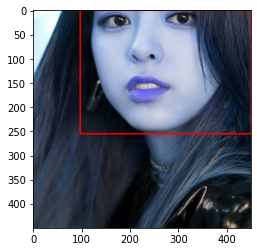

In [102]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])